In [30]:
import os
from rdflib import Graph 
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
# Load the graph
g = Graph()
g.parse("data/dunbar/bacnet.ttl", format="turtle")

<Graph identifier=Nc7ddeff2f06a40c089d27f049f76b365 (<class 'rdflib.graph.Graph'>)>

In [66]:
# Bacnet Devices

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Device
query_for_devices = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name
WHERE {
  ?device a bacnet:bacnet_Device ;
          bacnet:device_name ?device_name .
}
"""

# Run the query for devices
for row in g.query(query_for_devices):
    device_name = row[0]

    # Create the document
    content = device_name.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [45]:
# Bacnet Points

# Create the documents to load into the vector store
documents = []

# Define a SPARQL query for bacnet_Point
query_for_points = """
PREFIX bacnet: <http://data.ashrae.org/bacnet/2016#>

SELECT ?device_name ?point_name ?present_value ?unit
WHERE {
  ?point a bacnet:bacnet_Point ;
         bacnet:device_name ?device_name ;
         bacnet:object_name ?point_name ;
         bacnet:present_value ?present_value ;
         bacnet:object_units ?unit .
}
"""

# Run the query for points
for row in g.query(query_for_points):
    device_name, point_name, present_value, unit = row
    
    content = point_name.value + " " + present_value.value + " " + unit.value
    documents.append(Document(page_content=content, metadata={"type": "bacnet_point"}))

In [67]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [68]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [69]:
# Computer required parameters of DBSCAN clustering
# Use KNN to find the optimal epsilon
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal epsilon
nbrs = NearestNeighbors(n_neighbors=5).fit(embs)

distances, indices = nbrs.kneighbors(embs)

distances = np.sort(distances, axis=0)

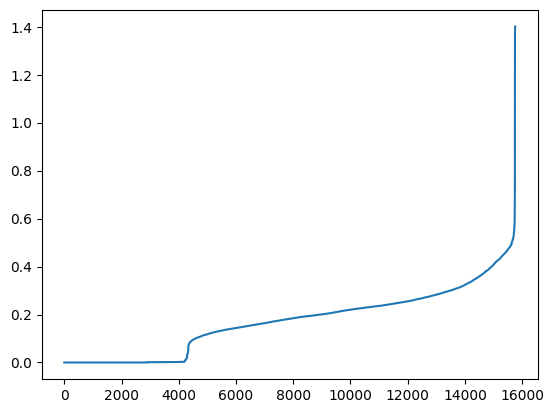

In [70]:
# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
import matplotlib.pyplot as plt

plt.plot(distances[:, 4])
plt.show()

In [71]:
# Use knee locator to find the optimal epsilon
from kneed import KneeLocator

kneedle = KneeLocator(
    range(1, distances.shape[0] + 1), distances[:, 1], curve="convex", direction="increasing"
)

kneedle.knee_y

0.4570407554029813

In [72]:
# Compute the DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.45, min_samples=5).fit(embs)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the results
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 82
Estimated number of noise points: 252


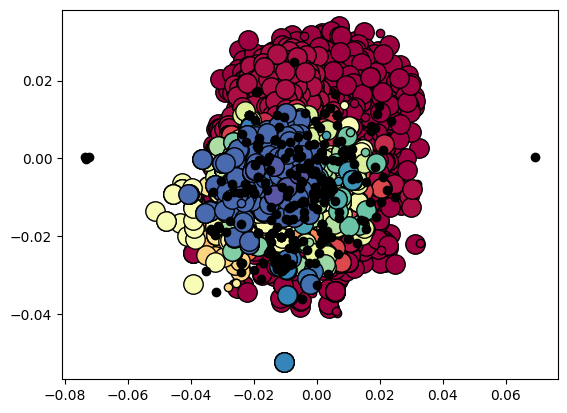

In [73]:
# Plot the results
import matplotlib.pyplot as plt

unique_labels = set(labels)
embs = np.array(embs)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6) 

In [74]:
# Create a dict of clusters and their bacnet devices
clusters = {}
for i in range(min(len(labels), len(documents))):
    if labels[i] in clusters:
        clusters[labels[i]].append(documents[i].page_content)
    else:
        clusters[labels[i]] = [documents[i].page_content]

# Pretty print the clusters dict
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters)

{   -1: ['BTU METER 1022', 'WSHP-35', 'EF-18', 'WSHP-14'],
    0: [   'Engineering',
           'Engineering',
           'Eaton Drive-1',
           'Eaton Drive-11',
           'BTU METER 1020',
           'Eaton Drive-3',
           'AHU-3 AFMS',
           'ATV212',
           'Eaton Drive-5',
           'Eaton Drive-7',
           'pCOWeb88004',
           'enteliBUS Manager 4104766',
           'HOT WATER PLANT',
           '',
           'B-WING VAVS',
           'AHU1',
           'AHU3',
           'AHU5',
           'C-WING RTU DOAS1&6',
           "DOAS-3&5 VAV'S",
           'A-WING FLOORS 1&2',
           'Eaton Drive-14',
           'Eaton Drive-17',
           'AHU-1 AFMS',
           'Eaton Drive-19',
           'ATV212',
           'VAV-D2-43',
           'VAV-D2-42',
           'VAV-D2-38',
           'VAV-D2-37',
           'RHVAV-A3-26',
           'VAV-D2-36',
           'VAV-D2-35',
           'VAV-D2-31',
           'VAV-D2-30',
           'RHVAV-A3-25',
        